In [1]:
import os
import warnings
from pathlib import Path

import cartopy
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML

found 24 itimes with 72-h forecasts in casedir /glade/campaign/mmm/parc/mwong/ufs-mrw


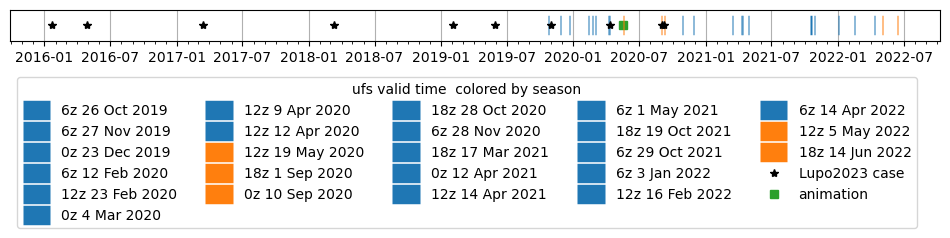

In [11]:
casedir = Path("/glade/campaign/mmm/parc/mwong/ufs-mrw")
workdir = Path(os.getenv("SCRATCH")) / "ks21_tmp"

# Choose a forecast length (24, 48, 72, or 240 work)
forecast_length = 72

# Choose an initialization time index
itime_index = 8

cases = sorted(casedir.glob(f"[12]?????????.F{forecast_length:03d}.C768"))
fmt = "%Y%m%d%H"
itimes = [pd.to_datetime(c.name[:10], format=fmt) for c in cases]

print(
    f"found {len(itimes)} itimes with {forecast_length}-h forecasts in casedir {casedir}"
)
assert itime_index < len(itimes) - 1, f"itime_index must be less than {len(itimes)}"
pd.Series(itimes, name="itime")
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 0.4))
ax.plot()
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
lw = 14
for itime in itimes:
    color = None
    if itime.month >= 5 and itime.month <= 9:
        color = "C1"  # element in axes color prop cycler
    vtime = itime + forecast_length * pd.Timedelta(hours=1)
    ax.hlines(
        0, itime, vtime, label=vtime.strftime("%-Hz %-d %b %Y"), color=color, lw=lw
    )
Lupo_cases_Table2 = (
    "20160123",
    "20160427",
    "20170315",
    "20180310",
    "20190203",
    "20190529",
    "20191031",
    "20200411",
    "20200902",
    "20200908",
)
ax.plot(
    [pd.to_datetime(d) for d in Lupo_cases_Table2],
    [0.00] * len(Lupo_cases_Table2),
    "*",
    label="Lupo2023 case",
    color="black",
)
ax.plot(
    itimes[itime_index],
    0.00,
    "s",
    label="animation",
    zorder=0,
    color="C2",
)
ax.legend(loc="upper left", bbox_to_anchor=(0.0, -0.96), title="ufs valid time  colored by season", ncol=5)
ax.grid()

In [3]:
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")

na_values = {
    "ID": -1,
    "ZMIN(m)": -9999.90,
    "ZLAT(N)": -9999.90,
    "ZLON(E)": -9999.90,
    "DY(km)": -9999.90,
    "DX(km)": -9999.90,
    "DIST(km)": -9999.90,
    "MAXDUR(h)": -9999.90,
    "PTY-OVR": 9999.90,
    "FERRY(km)": -99999.90,
    "FERRX(km)": -99999.90,
    "FERR(km)": -99999.90,
    "VLat(N)": -9999.90,
    "VLon(E)": -9999.90,
    "VSo": -9999.90,
    "VRo": -9999.90,
    "VZmin": -9999.90,
}

def tissot(ax, df, **kwargs):
    ts = []
    for i, row in df.iterrows():
        t = ax.tissot(
            rad_km=row["Ro(km)"],
            lons=row["LON(E)"],
            lats=row["LAT(N)"],
            **kwargs,
        )
        ts.append(t)
    return ts


def label_id(ax, df, **kwargs):
    for i, row in df.iterrows():
        x=row["LON(E)"]
        y=row["LAT(N)"]
        dx = row["FERRX(km)"]/(111*np.cos(np.radians(y)))
        dy = row["FERRY(km)"]/111.
        if np.isnan(dy):
            continue
        t = ax.text(
            x=x,
            y=y,
            s=f'{row["ID"]:.0f}',
            **kwargs,
        )
        ncolors = len(plt.rcParams['axes.prop_cycle'])
        color = f'C{int(row["ID"]) % ncolors}'
        ax.plot([x-dx, x], [y-dy, y], transform=cartopy.crs.Geodetic(), color=color)
    return

text_kw = dict(
    fontsize="xx-small",
    horizontalalignment="center",
    verticalalignment="center",
    transform=cartopy.crs.PlateCarree(),
)


def animate(i):
    ctime = ctimes[i]
    sfx = ".track"
    obs_path = ctime.strftime(
        "/glade/u/home/klupo/work_new/postdoc/kasugaEA21/version9/HGT_500mb/"
        f"gfs.0p25.%Y%m%d%H.f000{sfx}"
    )
    obs = pd.read_csv(
        obs_path,
        header=0,
        sep=r"\s+",
        na_values=na_values,
    )
    plt.cla()
    ax.set_global()
    ax.coastlines()
    ax.gridlines(lw=0.25, alpha=0.5)

    ts = tissot(ax, obs, alpha=0.2, color="k")
    ids = label_id(
        ax,
        obs,
        **text_kw,
    )

    fhr = (ctime - ctimes[0]) / pd.Timedelta(hours=1)
    if fhr == 0:
        sfx = ".dat"  # no .track file for f000, for some reason
    df = pd.read_csv(
        workdir
        / itime.strftime(fmt)
        / f"diag_TroughsCutoffs.{itime.strftime(fmt)}.f{fhr:03.0f}{sfx}",
        header=0,
        sep=r"\s+",
        na_values=na_values,
    )
    ax.set_title(f"{ctime} f{fhr:03.0f}")
    ts.extend(tissot(ax, df, alpha=0.4, facecolor="white", edgecolor="C0"))
    if fhr > 0:
        ids = label_id(
            ax,
            df,
            color="C0",
            **text_kw,
        )

    return ts

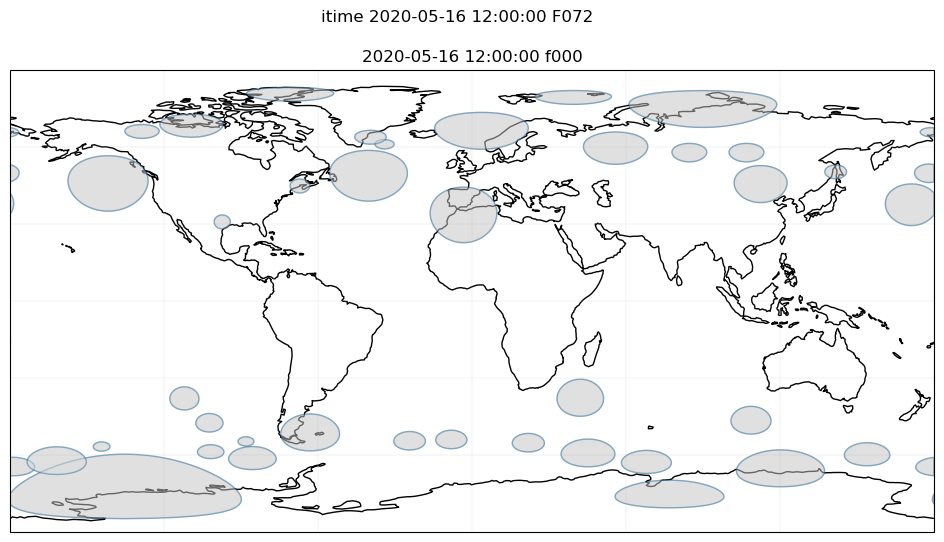

In [4]:
# Choose one of the initializations of itimes.
itime = itimes[itime_index]
fig, ax = plt.subplots(
    figsize=(12, 6),
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
)
fig.suptitle(f"itime {itime} F{forecast_length:03d}")
leadtime = pd.Timedelta(hours=forecast_length)
ctimes = pd.date_range(start=itime, end=itime + leadtime, freq="6h")
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(ctimes))

HTML(ani.to_jshtml())

## Analyze all track files, regardless of forecast length

In [14]:
files = workdir.glob("[12]?????????/diag_TroughsCutoffs.??????????.f???.track")

df = pd.concat(
    [
        pd.read_csv(
            f,
            header=0,
            sep=r"\s+",
            na_values=na_values,
        )
        for f in files
    ],
    ignore_index=True,
)
df["FHOUR"] = df["FHOUR"].str.lstrip("f").astype(float)
df["ITIME"] = pd.to_datetime(df["ITIME"], format="%Y%m%d%H")
df["FDAY"] = (df["FHOUR"] / 24).astype(int)
df = df[df["FHOUR"] <= 24]
df

ITIME  FHOUR       ID  So(m/100km)  LAT(N)  LON(E)  \
0     2020-09-09 00:00:00   12.0  38676.0        26.77   83.00  239.25   
1     2020-09-09 00:00:00   12.0  38694.0        12.77   78.00   80.25   
2     2020-09-09 00:00:00   12.0  38652.0        16.21   72.00    7.75   
3     2020-09-09 00:00:00   12.0  38711.0        11.13   70.25   48.00   
4     2020-09-09 00:00:00   12.0  38703.0        11.40   68.00  298.75   
...                   ...    ...      ...          ...     ...     ...   
57498 2022-06-12 18:00:00   24.0  52030.0        28.02  -66.50  285.50   
57499 2022-06-12 18:00:00   24.0  52043.0        11.99  -68.00  118.50   
57500 2022-06-12 18:00:00   24.0      NaN        13.33  -68.50  321.25   
57501 2022-06-12 18:00:00   24.0  52001.0        13.29  -69.00  319.75   
57502 2022-06-12 18:00:00   24.0      NaN        25.94  -73.50  195.25   

       SoFlag  Ro(km)    SR  BGo(m/100km)  ...  FERRY(km)  FERRX(km)  \
0           0   500.0  0.35          9.38  ...       0.00     -20.33   
1           0   500.0  0.90         11.55  ...      27.81      76.69   
2           0   600.0  0.19          3.07  ...       0.00      25.78   
3           1   300.0  1.79         19.91  ...       0.00      -9.40   
4           1   800.0  0.70          7.93  ...      27.81     136.86   
...       ...     ...   ...           ...  ...        ...        ...   
57498       0   600.0  0.89         24.82  ...     333.68     291.96   
57499       0   700.0  1.41         16.91  ...    -139.03      76.83   
57500      -1   400.0  0.92         12.25  ...        NaN        NaN   
57501       0   400.0  0.83         11.04  ...     -83.42     -30.91   
57502      -1  1100.0  0.24          6.26  ...        NaN        NaN   

       FERR(km)  T(0)/M(1)/N  VLat(N) VLon(E)    VSo    VRo    VZmin  FDAY  
0         20.33            0    83.00  240.75  26.94  500.0  5109.64     0  
1         80.85            0    77.75   77.00  12.63  600.0  5379.45     0  
2         25.78            0    72.00    7.00  15.22  600.0  5233.78     0  
3          9.40            1    70.25   48.25  10.84  300.0      NaN     0  
4        138.94            0    67.75  295.50  11.90  400.0      NaN     0  
...         ...          ...      ...     ...    ...    ...      ...   ...  
57498    456.56            0   -69.50  278.00  26.41  900.0  4793.32     1  
57499    157.90            1   -66.75  116.75  12.47  600.0  5123.95     1  
57500       NaN           -1      NaN     NaN    NaN    NaN      NaN     1  
57501     88.79            0   -68.25  320.50  14.20  400.0      NaN     1  
57502       NaN           -1      NaN     NaN    NaN    NaN      NaN     1  

[14555 rows x 53 columns]

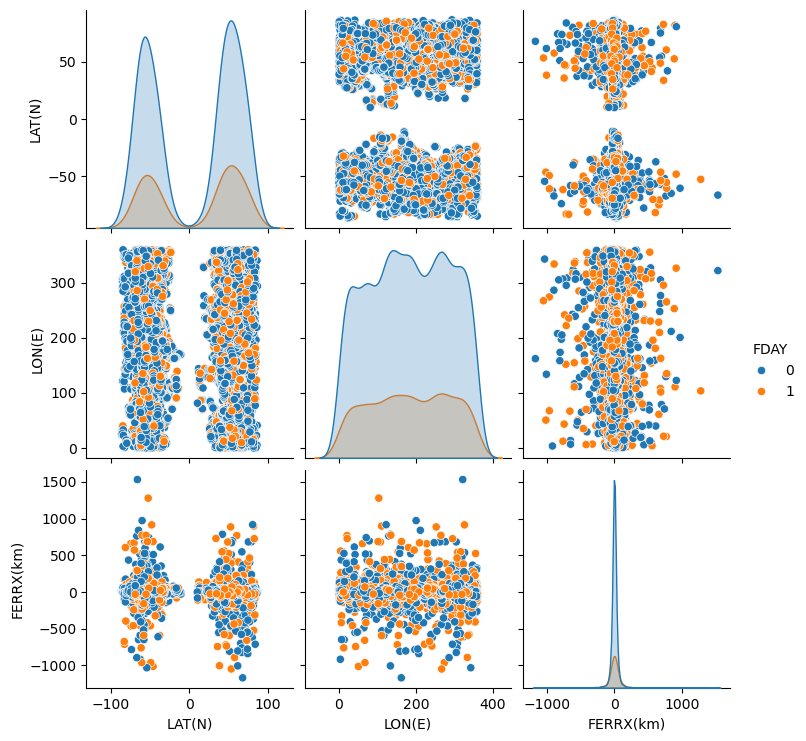

In [16]:
sns.pairplot(
    df[df["MAXDUR(h)"]>=36], vars=["LAT(N)", "LON(E)", "FERRX(km)"], hue="FDAY"
)

In [17]:
df.describe().loc["mean"]

ITIME               2021-01-06 01:40:48.890415616
FHOUR                                   15.001031
ID                                   41161.112085
So(m/100km)                             18.435083
LAT(N)                                   2.356733
LON(E)                                  182.27427
SoFlag                                   0.005977
Ro(km)                                 594.572312
SR                                       0.980021
BGo(m/100km)                            16.615685
BGo-lat(m/100km)                        -1.932104
BGo-lon(m/100km)                         0.351104
ZMIN(m)                               5193.229615
ZLAT(N)                                  4.674937
ZLON(E)                                182.814436
Z850(m)                               1298.115088
Z500(m)                               5287.915749
Z200(m)                              11429.307633
T850(K)                                267.370024
T500(K)                                245.227283


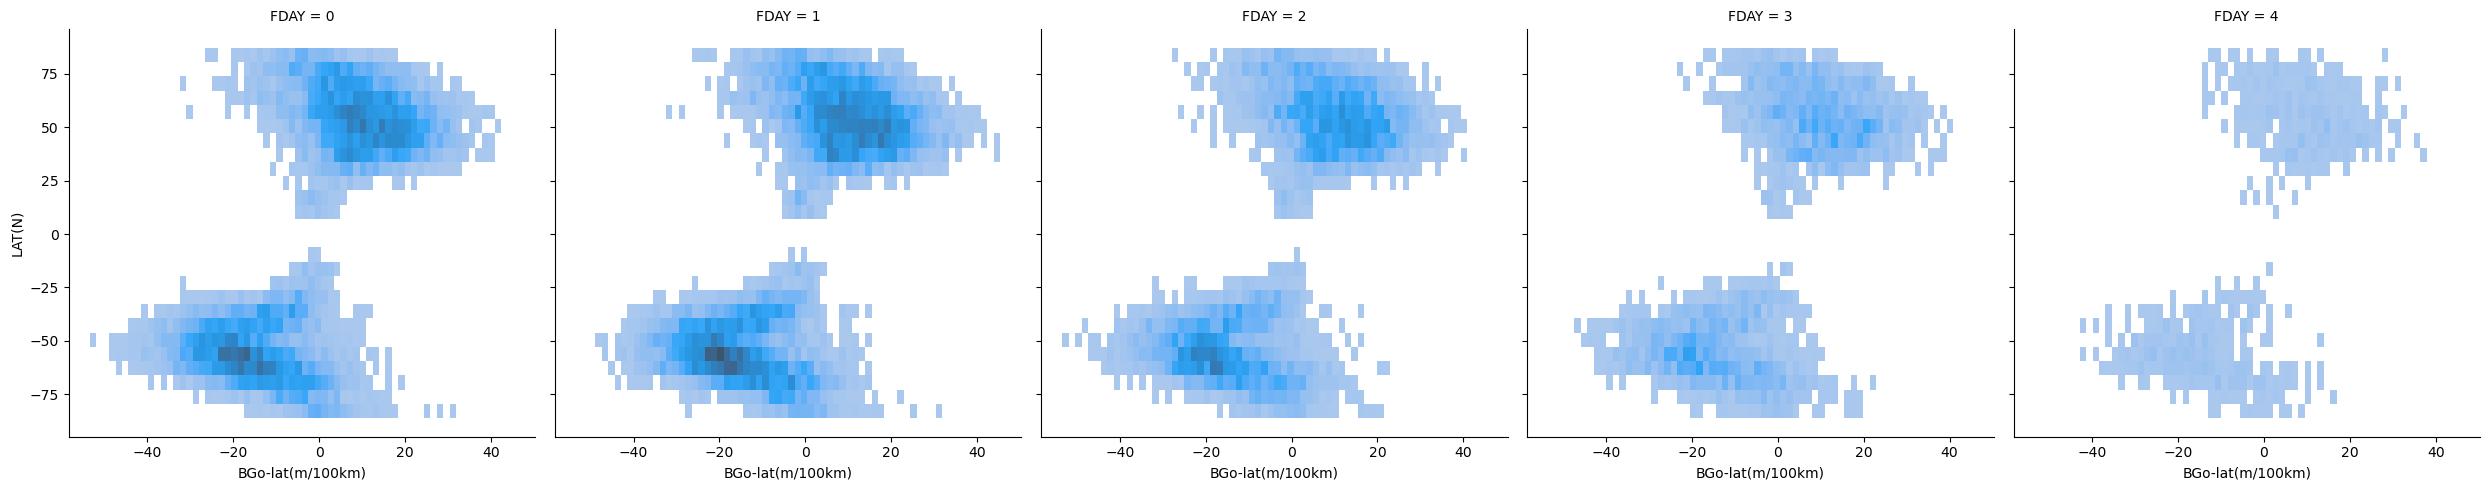

In [8]:
sns.displot(data=df, x='BGo-lat(m/100km)', y="LAT(N)", col="FDAY")